In [171]:
#ZAD1
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

sia = SentimentIntensityAnalyzer()


In [172]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [173]:
data = pd.read_csv('sample.csv')

In [174]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [175]:
data['cleaned_text'] = data['comment_text'].apply(preprocess_text)

In [176]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))  # 1-2 grams
tfidf_matrix = vectorizer.fit_transform(data['cleaned_text'])

In [199]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=3)

In [200]:
data['cluster'] = kmeans.labels_

In [201]:
sarcasm_markers = ['yeah right', 'sure', 'totally', 'not really', 'of course', 'lol']

In [202]:
def detect_sarcasm(text):
    for marker in sarcasm_markers:
        if marker in text:
            return True
    return False

In [203]:
data['sarcasm'] = data['cleaned_text'].apply(detect_sarcasm)

In [204]:
irony_markers = [
    'oh really', 'how surprising', 'of course not', 'what a surprise', 
    'unexpected', 'how ironic', 'as if', 'so unexpected', 'right, because that works'
]

In [205]:
def detect_irony(text):
    for marker in irony_markers:
        if marker in text:
            return True
        
    sentiment = sia.polarity_scores(text)
    if sentiment['pos'] > 0.5 and sentiment['neg'] > 0.5:
        return True
    return False

In [206]:
data['irony'] = data['cleaned_text'].apply(detect_irony)

In [207]:
sarcasm_count = data['sarcasm'].sum()
irony_count = data['irony'].sum()
non_sarcastic_or_ironic_count = len(data) - sarcasm_count - irony_count

In [208]:
labels = ['Non-Sarcastic/Non-Ironic', 'Sarcastic', 'Ironic']
counts = [non_sarcastic_or_ironic_count, sarcasm_count, irony_count]

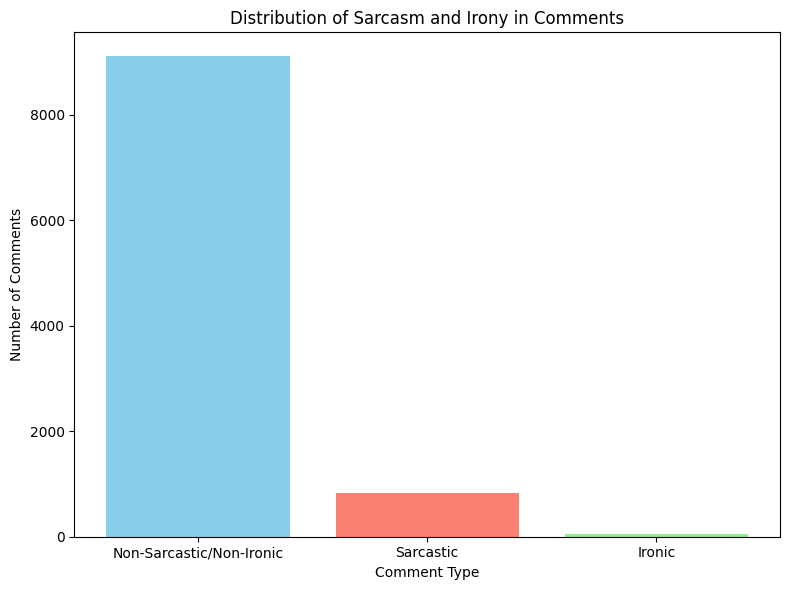

In [209]:
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sarcasm and Irony in Comments')
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()